In [102]:
from KoopmanismResponse.dynamical_systems.Models import Arnold_map
from KoopmanismResponse.utils.data_processing import (
    get_spectral_properties,
    get_acf,
    Koopman_correlation_function,
    get_observables_response_ArnoldMap
)
from KoopmanismResponse.utils.paths import get_data_folder_path
from KoopmanismResponse.EDMD.EDMD import Edmd_Fourier, TSVD
import numpy as np
from matplotlib import pyplot as plt
import pickle
from typing import List, Optional

In [103]:
two_dim_map = Arnold_map()

In [104]:
two_dim_map.set_random_initial_condition()
two_dim_map.M = 2*10**6
t, X = two_dim_map.integrate()

100%|██████████| 2000000/2000000 [00:28<00:00, 70921.29it/s]


In [105]:
# Setting EDMD
edmd = Edmd_Fourier()
edmd.max_wave_vector = 8
edmd.box_length = 1
edmd._set_indices()

# Perform algorithm and get spectral properties
K = edmd.perform_edmd(data=X)
nus, V, W = get_spectral_properties(K)

100%|██████████| 200/200 [00:38<00:00,  5.21it/s]


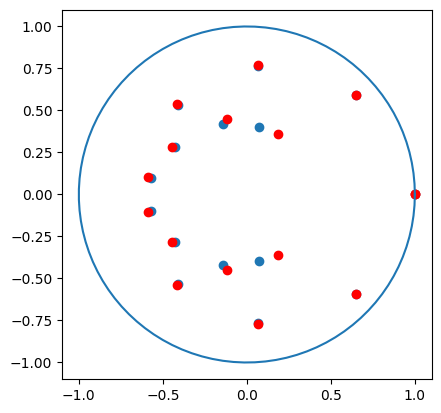

In [106]:
fig, ax = plt.subplots()
thetas = np.linspace(0,2*np.pi,100)
ax.plot(np.cos(thetas),np.sin(thetas))
ax.set_aspect('equal')
threshold = 0.6
indx = np.where(np.abs(nus) < threshold)[0][0]
nus_plot = nus[:15]
ax.scatter(np.real(nus_plot), np.imag(nus_plot))
mu = two_dim_map.mu_abs * np.exp(1j*( two_dim_map.alpha))
nus_det = (- mu)**(np.arange(8))
ax.scatter(np.real(nus_det),np.imag(nus_det),color='r')
ax.scatter(np.real(nus_det),-np.imag(nus_det),color='r')


Text(0.5, 0, '$t$')

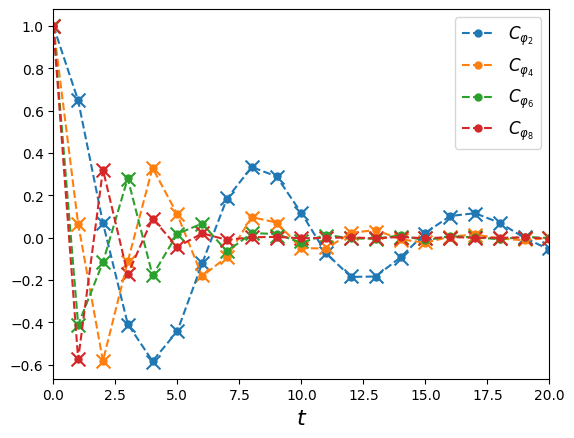

In [107]:
numbers = [1,3,5,7]
nlags = 30
max_time = min(X.shape[0],10**5)
Phi_traj = edmd.evaluate_koopman_eigenfunctions_batch(X[:max_time,:],V)
fig , ax = plt.subplots()

for i,number in enumerate(numbers):
    lags, cf = get_acf(Phi_traj[:,number], nlags = nlags,Dt=1)
    cf_th = np.real( nus[number]**lags )
    ax.plot(lags,cf/cf[0],'--o',label= fr"$C_{{ \varphi_{number+1} }}$",markersize=5 )
    ax.scatter(lags,cf_th /cf_th[0],marker= 'x',s=100 )
    ax.set_xlim(0,20)
    
ax.legend(fontsize=12)
ax.set_xlabel("$t$",size=16)   

In [108]:
# # Projection onto the subspace spanned by the leading n selected modes
# Vn = V[:,:indx]
# nus_good = nus[:indx]
# G_koop_n = Vn.T.conj() @ edmd.G @ Vn

In [109]:
# Correlation functions from trajectory
x , y = X[:max_time,0] , X[:max_time,1]
observables = [np.sin(2*np.pi*x)*np.sin(2*np.pi*y) , x**2 + y**2 , np.atan(x)*np.log(y + 0.1)]
cf_num = [get_acf(obs,nlags = nlags,Dt=1)[1] for obs in observables]

# Taking the projections w.r.t. Lebesgue of the functions
grid = np.linspace(0,1,200)
dx = grid[1] - grid[0]
dV = dx**2

Xg , Yg = np.meshgrid(grid,grid,indexing='ij')
grid_points = np.stack([Xg.ravel(), Yg.ravel()], axis=1)

observables = [
    np.sin(2 * np.pi * Xg) * np.sin(2 * np.pi * Yg),
    Xg**2 + Yg**2,
    np.atan(Xg) * np.log(Yg + 0.1)
]
observables_vals = [obs.ravel() for obs in observables]


Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_points)
projections =  [  Psi_Lebesgue.T.conj() @ (obs * dV) for obs in observables_vals] 

/Users/niccolo/Desktop/Koopmanism_Response/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/niccolo/Desktop/Koopmanism_Response/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


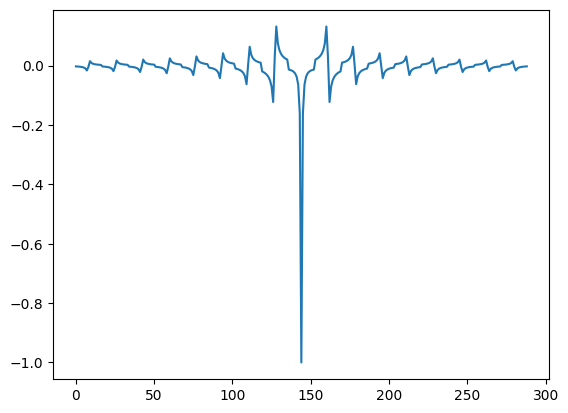

In [110]:
plt.plot(projections[-1]/ np.max(np.abs(projections[-1])))

In [111]:
# Evaluate the Koopman projections and the reconstruction
Koop_projections = [W.conj().T @ proj for proj in projections] #[np.linalg.pinv(G_koop_n) @ Vn.conj().T @ edmd.G @ proj for proj in projections] #
M = V.conj().T @ edmd.G @ V 
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=M, eigenvalues=nus, alpha1=koop_proj, alpha2=koop_proj
    ) for koop_proj in Koop_projections
]

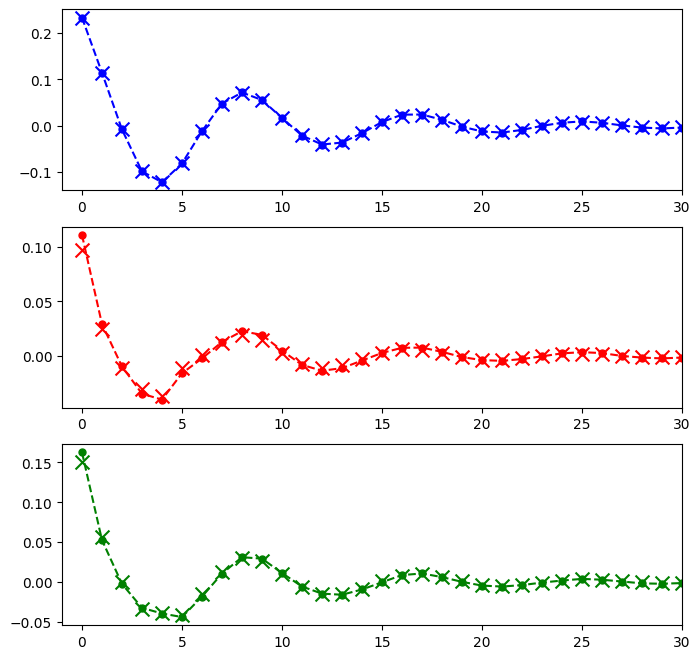

In [112]:
fig, ax = plt.subplots(nrows=3,figsize=(8,8))
labels = [f"$x$", f"$\sin^2(x)$" , f"$\ln(x+\delta)$"]
colors = ['b','r','g']
for index , (cf, Koop_rec,label)  in enumerate( zip( cf_num , Koop_reconstruction, labels) ):
    Koop_cf = np.real( np.asarray( [Koop_rec(lag) for lag in lags] ) )

    ax[index].plot(lags,cf,'--o',markersize=5,label=label,color=colors[index])
    ax[index].scatter(lags,Koop_cf ,s=100,marker="x",c=colors[index])

    ax[index].set_xlim(-1,30)
# ax.legend()

### Response

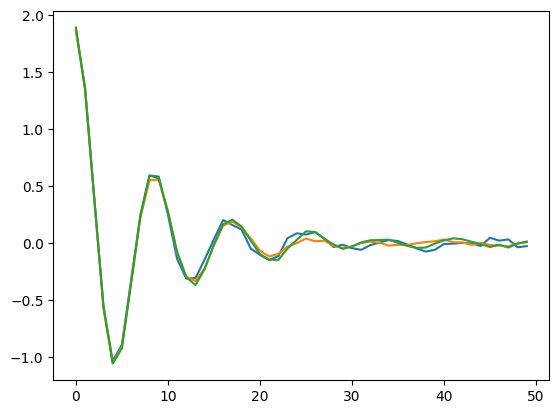

In [113]:
data_folder_path = get_data_folder_path()
f_name = "response_two_dimensional_map_sinusoidal_perturbation.pkl"

with open(data_folder_path / f_name,"rb") as f:
    response_experiments_results = pickle.load(f)

RP = response_experiments_results["Positive Response"]
RM = response_experiments_results["Negative Response"]
amplitudes = response_experiments_results["Amplitudes"]
response_settings = response_experiments_results["Response Settings"]

t_resp = np.arange(1,response_settings.M+1)
G = np.zeros(RP[0].shape)
individual_responses = []
for rp , rm , amplitude in zip(RP,RM,amplitudes):
    response = (rp - rm) / (2*amplitude) 
    individual_responses.append(response)
    G +=  response
    
G /= len(amplitudes)

fig, ax = plt.subplots()
for x in individual_responses:
    ax.plot(x[:,1])

In [114]:
# Finding projections of the observables
obs_grid = get_observables_response_ArnoldMap(grid_points)
projections =  [ ( Psi_Lebesgue.T.conj() @ obs * dV) for obs in obs_grid.T] 
# Evaluate the Koopman projections and the reconstruction
Koop_projections =  [W.conj().T @ proj for proj in projections] # [np.linalg.pinv(G_koop_n) @ Vn.conj().T @ edmd.G @ proj for proj in projections]

obs_trajectory = get_observables_response_ArnoldMap(X)
cf_num = [get_acf(obs,nlags = nlags,Dt=1)[1] for obs in obs_trajectory.T]

Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=M, eigenvalues=nus, alpha1=koop_proj, alpha2=koop_proj
    ) for koop_proj in Koop_projections
]

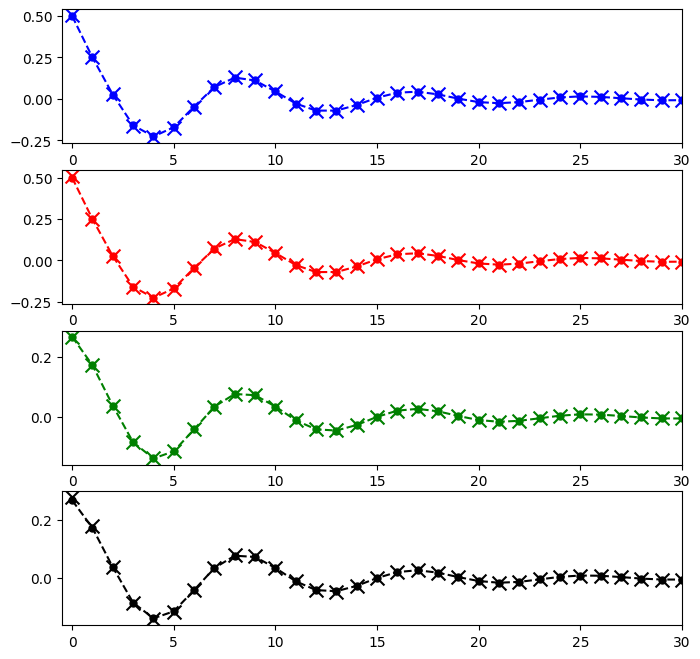

In [115]:
fig, ax = plt.subplots(nrows=4,figsize=(8,8))
colors = ['b','r','g','k']
for index , (cf, Koop_rec)  in enumerate( zip( cf_num , Koop_reconstruction) ):
    Koop_cf = np.real( np.asarray( [Koop_rec(lag) for lag in lags] ) )

    ax[index].plot(lags,cf,'--o',markersize=5,label=label,color=colors[index])
    ax[index].scatter(lags,Koop_cf ,s=100,marker="x",c=colors[index])

    ax[index].set_xlim(-0.5,30)
# ax.legend()

In [130]:
Gamma_data = Arnold_map()
Gamma_data.M = 5*10**5
Gamma_data.set_random_initial_condition()
t, X_Gamma = Gamma_data.integrate()

x_Gamma , y_Gamma = X_Gamma[:,0] , X_Gamma[:,1]

100%|██████████| 500000/500000 [00:07<00:00, 69335.96it/s]


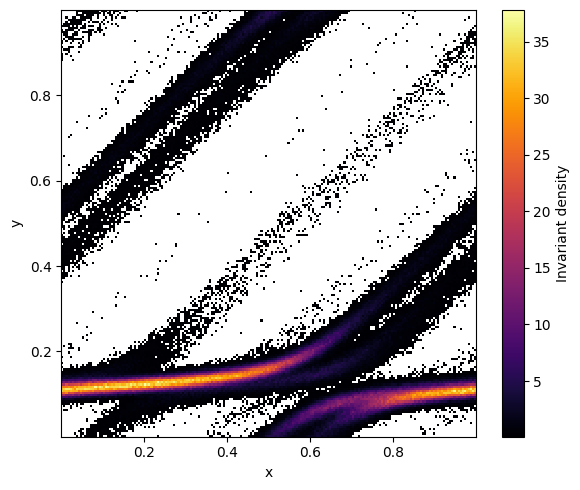

In [131]:
rho0 , edges = np.histogramdd(X_Gamma,bins=[200,200],density=True)

rho_plot = rho0.copy()
rho_plot[rho_plot < 10**(-4)] = np.nan
xedges , yedges = edges

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
dV = dx*dy

# Coordinates for plotting (bin centers)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
Xc, Yc = np.meshgrid(xcenters, ycenters, indexing='ij')

# Plot
plt.figure(figsize=(6, 5))
plt.pcolormesh(Xc, Yc, rho_plot, cmap='inferno')
plt.colorbar(label='Invariant density')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

In [140]:
grid_rho0 = np.stack([Xc.ravel(), Yc.ravel()], axis=1)

perturbation_amplitude = np.sin(2*np.pi*(Xc - 2* Yc))
eta = - perturbation_amplitude * rho0
eta_vals = eta.ravel()
# Find projections of eta
Psi_Lebesgue = edmd.evaluate_dictionary_batch(grid_rho0)
G_Lebesgue = Psi_Lebesgue.T.conj() @ Psi_Lebesgue * dV
eta_dictionary_projections = Psi_Lebesgue.T.conj() @ eta_vals * dV
eta_rec = (Psi_Lebesgue @ eta_dictionary_projections).reshape(Xc.shape)
wave_vectors =  [np.asarray(x) for x in edmd.indices]
gamma_dictionary_projections = [1j*2*np.pi /edmd.box_length * np.sum(k) * eta_proj for k,eta_proj in zip(wave_vectors,eta_dictionary_projections)]
gamma_koopman_projections = W.T.conj() @ gamma_dictionary_projections

G_gamma = V.conj().T @  V

In [141]:
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=G_gamma, eigenvalues=nus, alpha1=koop_proj, alpha2=gamma_koopman_projections
    ) for koop_proj in Koop_projections
]

G_reconstruction = np.stack( [np.real( np.asarray( [Koop_rec(t) for t in t_resp] ) ) for Koop_rec in Koop_reconstruction] ).T

(-0.5, 30.0)

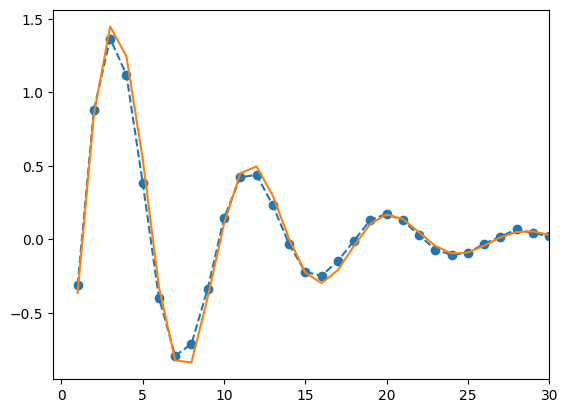

In [143]:
fig, ax = plt.subplots()
i = 0
ax.plot(t_resp,G[:,i],'--o')
ax.plot(t_resp,G_reconstruction[:,i])
ax.set_xlim(-0.5,30)

In [144]:
Psi_traj = edmd.evaluate_dictionary_batch(X_Gamma)
perturbation_field = np.sin(2*np.pi*(x_Gamma - 2*y_Gamma))
moms = ( perturbation_field[:,np.newaxis] * Psi_traj ).mean(axis=0)


Delta = [1j*2*np.pi /edmd.box_length*np.sum(k)*mom for mom, k in zip(moms,wave_vectors)]
Gamma_dictionary_projections = np.linalg.pinv(edmd.G) @ Delta
Gamma_Koopman_projections = W.conj().T @ Gamma_dictionary_projections

In [145]:
Koop_reconstruction = [
    lambda t, koop_proj=koop_proj: Koopman_correlation_function(
        t=t, M=M, eigenvalues=nus, alpha1=koop_proj, alpha2=Gamma_Koopman_projections
    ) for koop_proj in Koop_projections
]

G_reconstruction = np.stack( [np.real( np.asarray( [Koop_rec(t) for t in t_resp] ) ) for Koop_rec in Koop_reconstruction] ).T

(-0.5, 30.0)

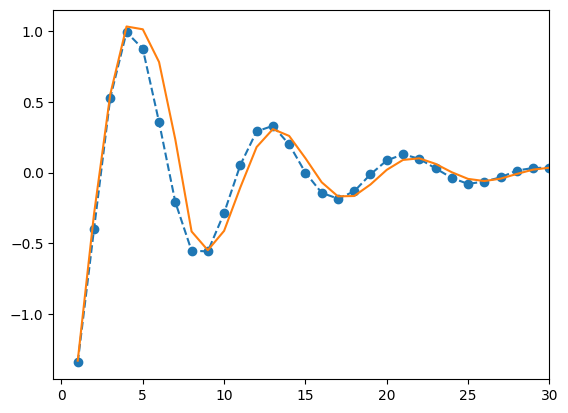

In [ ]:
fig, ax = plt.subplots()
i = 1
ax.plot(t_resp,G[:,i],'--o')
ax.plot(t_resp,-G_reconstruction[:,i])
ax.set_xlim(-0.5,30)

In [ ]:
# rho0 , edges = np.histogramdd(X,bins=[200,200],density=True)

# rho_plot = rho0.copy()
# rho_plot[rho_plot < 10**(-4)] = np.nan
# xedges , yedges = edges

# # Coordinates for plotting (bin centers)
# xcenters = (xedges[:-1] + xedges[1:]) / 2
# ycenters = (yedges[:-1] + yedges[1:]) / 2
# Xc, Yc = np.meshgrid(xcenters, ycenters, indexing='ij')

# # Coordinates for plotting (bin centers)
# xcenters = (xedges[:-1] + xedges[1:]) / 2
# ycenters = (yedges[:-1] + yedges[1:]) / 2
# Xc, Yc = np.meshgrid(xcenters, ycenters, indexing='ij')

# # Plot
# plt.figure(figsize=(6, 5))
# plt.pcolormesh(Xc, Yc, rho_plot, cmap='inferno')
# plt.colorbar(label='Invariant density')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.tight_layout()

In [ ]:
edmd.indices
